# **Idealista EDA**
*Jose Ramon Estevez Melgarejo 2022-04-10.*

## Introduction
This is the second third of my idealista portfolio´s project. 
In this notebook we will explore the data we extracted and cleaned in the previous notebooks of this project. Input data should be clean and ready to be analysed. Here we are going to explore each variable and its relationship to price per m<sup>2</sup> as the final goal of this project will be to develop a machine learning model to estimate the price of a property. No feature ingeniering will be done in this notebook.

## 1. Importing Libraries & reading data

In [351]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd
import folium

In [352]:
data = pd.read_csv('data/clean_data_3.csv') # Reading data into a pd.DataFrame
data['price_sq_m'] = data['price_act'] / data['sq_m'] # Creating price/m^2
data.head() 

,house_id,price_act,price_first,advertiser,type,nbhood,street,st_number,sq_m,bedrooms,...,const_year,floor,lift,balcony,air_con,ft_wardrobes,terrace,exterior,heating,price_sq_m
0,94283285,750000.0,750000.0,Professional advertiser,flat / apartment,zona bahia blanca,unknown,NaN,262.0,6.0,...,1973.0,10.0,1,1,1,1,1,1,individual,2862.595420
1,89113690,575000.0,575000.0,Professional advertiser,duplex,mentidero - teatro falla - alameda,unknown,NaN,135.0,3.0,...,1998.0,2.0,0,0,1,1,1,1,individual,4259.259259
2,95291210,320000.0,320000.0,Professional advertiser,flat / apartment,mentidero - teatro falla - alameda,unknown,NaN,190.0,8.0,...,1888.0,1.0,0,0,0,0,0,1,no,1684.210526
3,96746079,390000.0,390000.0,Professional advertiser,flat / apartment,mentidero - teatro falla - alameda,unknown,NaN,131.0,3.0,...,1796.0,3.0,1,1,1,1,0,1,no,2977.099237
4,96622572,720000.0,720000.0,Professional advertiser,flat / apartment,playa stª mª del mar,unknown,NaN,168.0,3.0,...,NaN,2.0,1,0,0,1,0,1,individual,4285.714286


## 2. Settings

We will simply set the theme style for our plots and create three different lists of each variable group (numeric, boolean & categorical). Theese lists will be handy later on when plotting.

In [353]:
sns.set_theme(style="ticks") # Setting sns theme style for all plats in this nb.

# Making a list with each var type
numeric_vars = ['price_act', 'price_first', 'sq_m', 'bedrooms', 'bathrooms', 'const_year', 'floor', 'st_number', 'price_sq_m']
bolean_vars = ['lift', 'balcony', 'air_con', 'ft_wardrobes', 'terrace', 'exterior']
categorical_vars = ['advertiser', 'type', 'nbhood', 'street','heating']

## 3. Analysis

In this section we will first explore the proportions or distributions of each variable on its own. Doing this we can have a general idea about what we are deling with, check for high cardinality, skewness, and any interesing insights that might appear. 

Then we will compare each variable with price per m<sup>2</sup> to have an idea of wich variables are more interesting when training our ml model in the next section. 

So the idea is to plot the information, writte a little description of it and enumerate the key findings if there are. 

### 3.1 Proportions and distributions

#### 3.1.1 Boolean variables proportions

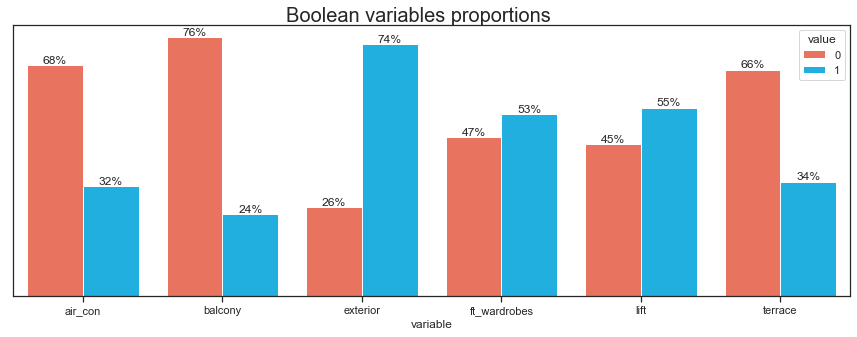

In [354]:
data_bol_tot_count = data[bolean_vars].melt().groupby('variable').size().reset_index(name='totals') # total count per class for percentages
data_bol = data[bolean_vars].melt().groupby(['variable', 'value']).size().reset_index(name='count').\
    merge(data_bol_tot_count, on='variable').assign(per = lambda x: x['count'] / x['totals'] * 100) # creating a df with % for each class

palette ={0: "tomato", 1: "deepskyblue"} # Creating custom palet for uor bolean vars.
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Boolean variables proportions', fontsize=20, y=0.93)
plot = sns.barplot(x="variable", y = 'per', hue="value", data=data_bol, palette=palette)

for container in ax.containers: # Adding labels
    ax.bar_label(container, fmt='%.f%%')

plot.axes.get_yaxis().set_visible(False) # Removing y axis
plt.show()

##### Coments

-   Air conditioning seems not to be a great deal in the city of Cadiz. Even though it is a pretty warm city, it seems looks like only 32% of the properties have air conditioning. 
-   It is interesting to see that 74% of the properties are considered as exterior but most of them do not have balcony (76%) or terrace (66%). It looks like sellers are optimistic when advertising their properties and they call it exterior if there is at least one window ;). I would say that terrace and balcony will be more desive when estimating price... we will see later if its true.
- Fitted wardroves and lift seem to be more or less equaly distributed.



#### 3.1.2 Categorical variables proportions

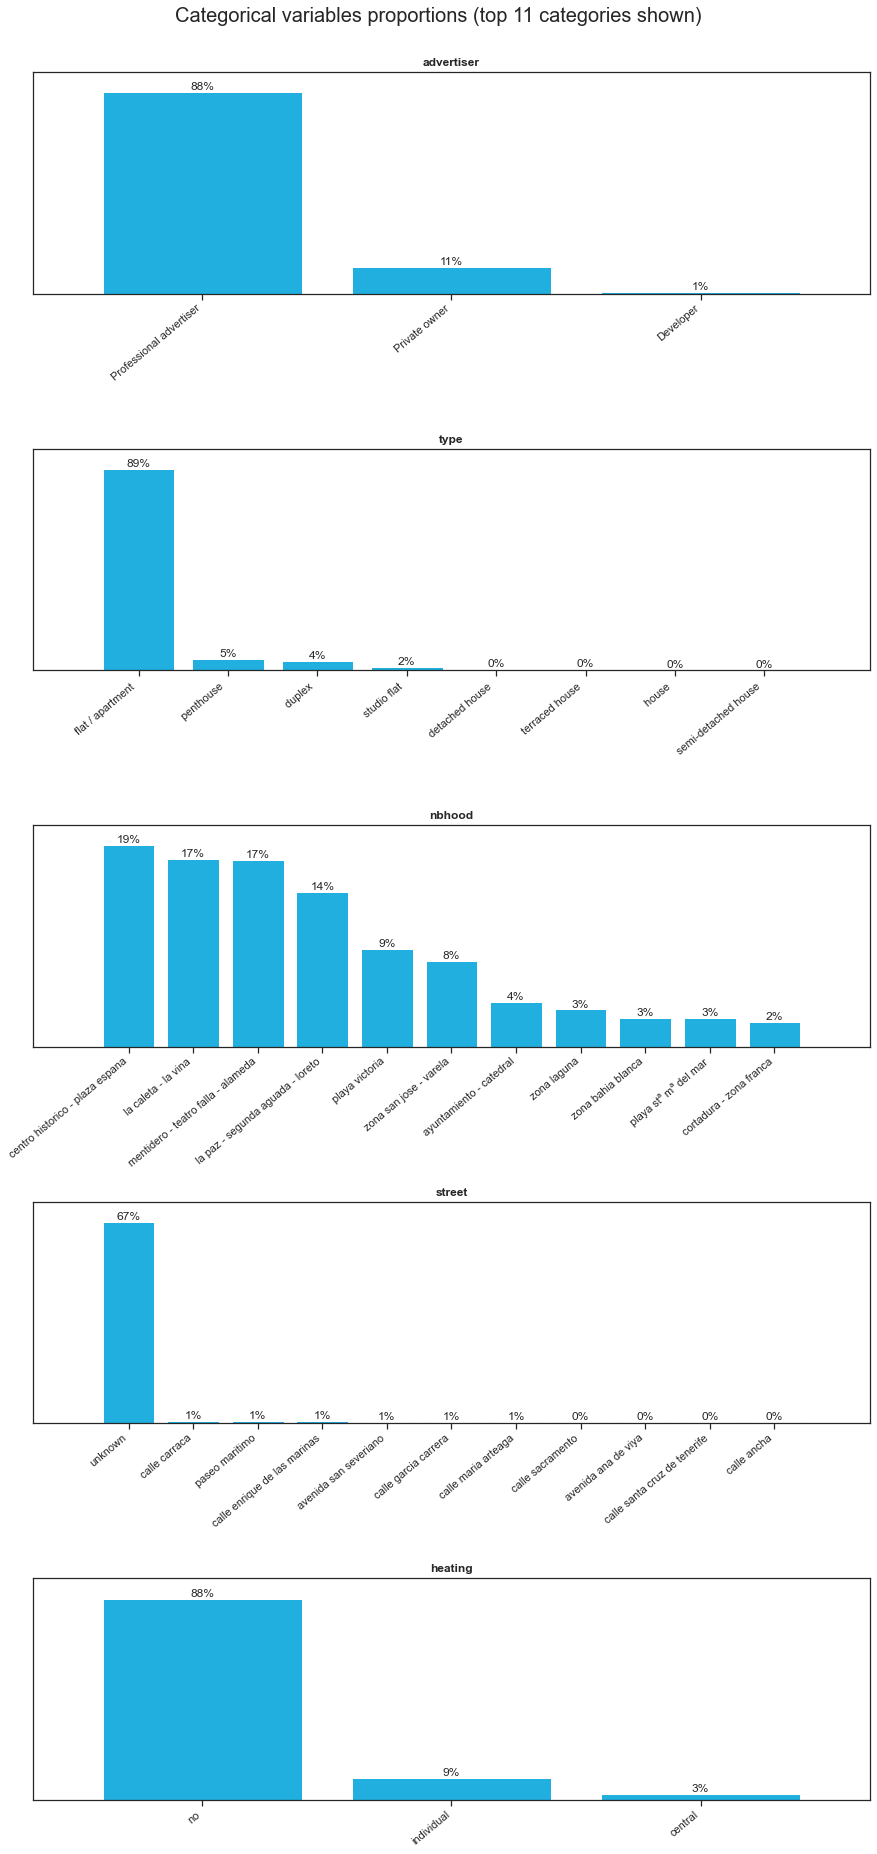

In [355]:
data_cat_tot_count = data[categorical_vars].melt().groupby('variable').size().reset_index(name='totals') # total count per class for percentages
data_cat = data[categorical_vars].melt().groupby(['variable', 'value']).size().reset_index(name='count').\
    merge(data_cat_tot_count, on='variable').assign(per = lambda x: x['count'] / x['totals'] * 100) # creating a df with % for each class
    
fig, axes = plt.subplots(5, 1, figsize=(15, 30))
axes = axes.flatten()
fig.suptitle('Categorical variables proportions (top 11 categories shown)', fontsize=20, y=0.93) # beacuse is the number of diferent neigborhoods
fig.subplots_adjust(hspace=0.7, bottom=0.1, top=0.9)

for i in range(len(categorical_vars)):
    var = categorical_vars[i]
    axes[i] = sns.barplot(ax=axes[i], x='value', y = 'per', data=data_cat[data_cat['variable'] == var], 
                            color='deepskyblue', order = data[categorical_vars[i]].value_counts().index[0:11])
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(labels = axes[i].get_xticklabels(), rotation=40, ha='right')
    axes[i].set_title(categorical_vars[i], fontweight="bold")
    axes[i].margins(0.1)

    for container in axes[i].containers: # Adding labels
        axes[i].bar_label(container, fmt='%.f%%')

    axes[i].get_yaxis().set_visible(False) # Removing y axis

##### Coments
- **Advertiser:**  Most of the sellers prefer to rely on an agency when selling their properties (88%). Also it makes sense to see that only 1% of the properties for sale are advertised by developers as Cadiz is nearly an island and there is not much more space to build.
-   **Type:** Most of the properties are flats/apartament (89%). As I said, space in Cadiz is limited and there are not many houses. 
-   **Neighborhood:** most of the available properties are located towards the end of the city (old town) where access is not so good and properties are older (checkout folium map later on).
-   **Street:** 67% of people hide their´s property exact location. Remember that idealista makes you pay to hide this information. With so many unknown addresses it doesnt make sense to take into acount this variable.
-   **Heating:** only 12% of properties declare to have any type of heating (not really needed in Cadiz). 

#### 3.1.3 Numeric variables histograms

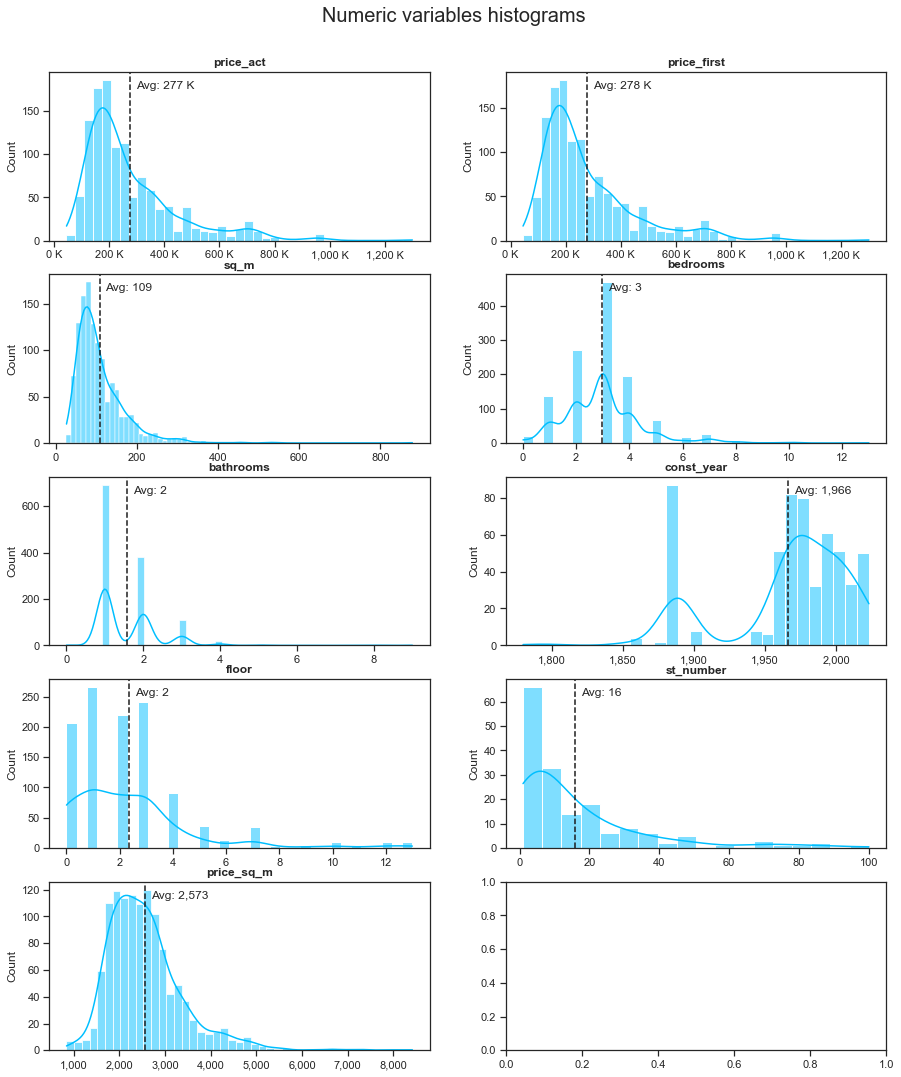

In [356]:
fig, axes = plt.subplots(5, 2, figsize=(15, 18))
axes = axes.flatten()
fig.suptitle('Numeric variables histograms', fontsize=20, y=0.93)

def th_formater(x, pos):
    return f'{x/1000:,.0f} K'

def coma_formater(x, pos):
    return f'{x:,.0f}'
    

for i in range(len(numeric_vars)):
    sns.histplot(ax=axes[i], x=data[numeric_vars[i]], kde=True, color='deepskyblue')
    axes[i].ticklabel_format(useOffset=False, style='plain')
    axes[i].set_xlabel('')
    axes[i].set_title(numeric_vars[i], fontweight="bold")
    
    var_mean = data[numeric_vars[i]].mean()
    axes[i].axvline(var_mean, color='k', linestyle='dashed', linewidth=1.5) # mean line
    annotation_y = axes[i].get_ylim()[1] * 0.9
    anotation_x = ((axes[i].get_xlim()[1] - axes[i].get_xlim()[0]) * 0.1 / 6.75) + var_mean # 6.75 is the length of the xaxis in pixels aprox
        
    # formatting hight xaxis labels
    if max(data[numeric_vars[i]]) > 100000: 
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(th_formater))
        axes[i].annotate(f'Avg: {var_mean/1000:,.0f} K', xy = (anotation_x, annotation_y))
    else:
        axes[i].annotate(f'Avg: {var_mean:,.0f}', (anotation_x, annotation_y))
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(coma_formater))
    



In [373]:
xaxa = 'sq_m'
print(min(data[xaxa]))
print(max(data[xaxa]))


27.0
879.0


##### Coments
-   Average price range for available properties is 45K - 1300K € and the average around 277K €. The histogram shows a little right skewness. 
-   Average starting price is around 278K €, nearly the same as the actual price. It sugests that peopple are not willing to lower the price and that  the market is stable. 
-   The standard flat is of around 109 m<sup>2</sup> ranging from 27 - 879 m<sup>2</sup>. The histogram shows also a bit of right skewness.
-   A three bedroom property is the most common one. 
-   Eventhough the average properti has 2 bathrooms the mode is 1 bathroom. Interesting to see that there are some properties with no bathroom probably there is a space but it isn´t not built yet.
-   We saw in the previous notebook that there is a lot of missing data for construction year but from those which we have some information we can see that the average construction year is around 1966. I think that this variable will be important when predicting price its a pity that there are so many NaN´s. 
-   Most common floor range from ground to 3rd. I am quite interesting to see if there is any correlation between floor number and price. My first thought is that top floors are more sunny and therefore a bit more expensive than the rest.
-   Not much to say about street number. Dont think it will be a good predictor at all. Maybe if we had all exact adresses we could do something with this.
-   Price per squared meter distribution looks pretty much as a Normal distribution. We don´t see observe the skewness present in price or starting price. It suggests that this price skewness is just a mater of squared meters.

### 3.2 Variables Vs Price m<sup>2</sup>

#### 3.2.1 Boolean variables Vs Price m<sup>2</sup>

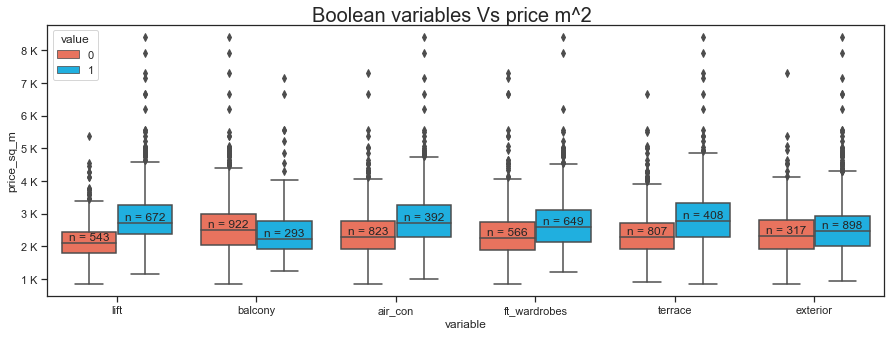

In [357]:
palette ={0: "tomato", 1: "deepskyblue"}
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Boolean variables Vs price m^2', fontsize=20, y=0.93)
data_bol = data[bolean_vars + ['price_sq_m']]
sns.boxplot(x='variable', y='price_sq_m', hue="value", data=data_bol.melt(id_vars='price_sq_m'), palette=palette)
ax.yaxis.set_major_formatter(plt.FuncFormatter(th_formater))

default_order = [] 
for element in ax.get_xmajorticklabels():
    default_order.append(element.get_text())
                                                  
medians_df = data_bol.melt(id_vars='price_sq_m').groupby(['variable', 'value']).agg(['median', 'count']).reset_index()
vjust = ((ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.06 / 6.25) # 6.25 is the hight of the yaxis in pixels aprox

for i in medians_df.variable.unique():
    ns = medians_df[medians_df.variable == i][[('value', ''), ('price_sq_m',  'count')]]
    for j in ns.value:
        n = ns[ns.value == j][('price_sq_m',  'count')].values[0]
        x = default_order.index(i)
        y = medians_df[(medians_df.variable == i) & (medians_df.value == j)][('price_sq_m',  'median')].values[0] + vjust
        if j == 0:
            x = x - 0.2
        else:
            x = x + 0.2
        
        ax.annotate(f'n = {n}', (x, y), horizontalalignment='center')

plt.show()

##### Coments

#### 3.2.2 Numeric variables Vs Price m<sup>2</sup>

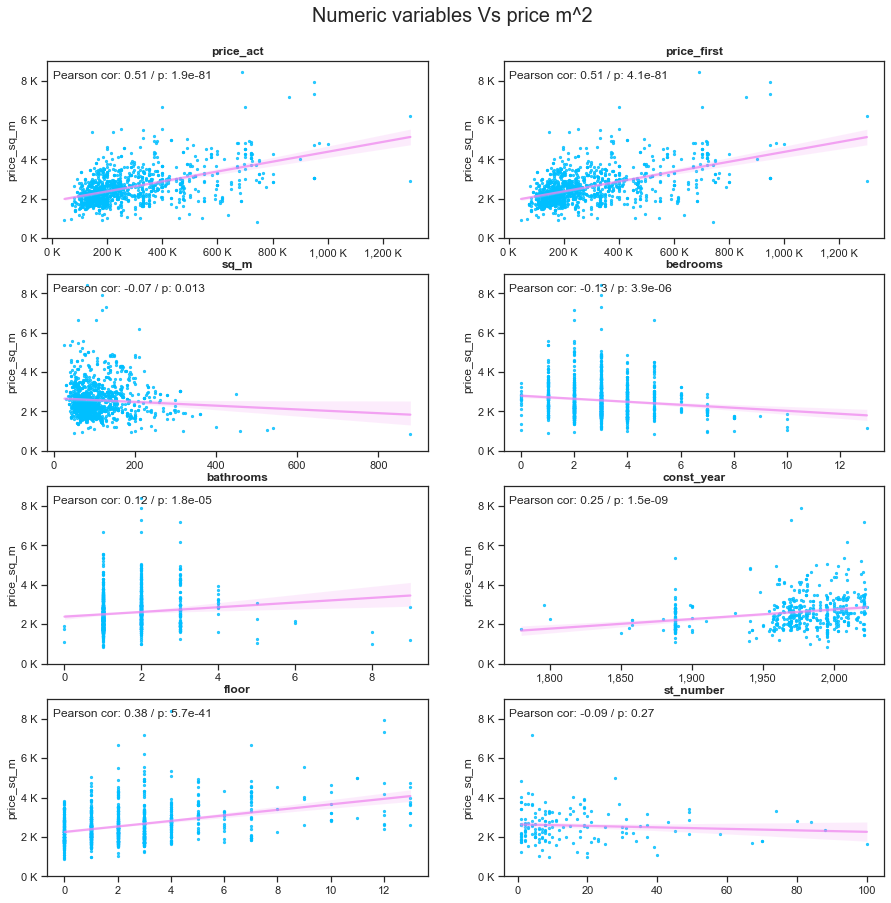

In [366]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()
fig.suptitle('Numeric variables Vs price m^2', fontsize=20, y=0.93)
numeric_vars_no_price_sq_m = [l for l in numeric_vars if l != 'price_sq_m']

for i in range(len(numeric_vars_no_price_sq_m)):
    sns.regplot(ax=axes[i], x=numeric_vars_no_price_sq_m[i], y='price_sq_m', color='deepskyblue', data=data, 
                scatter_kws={'s':5}, line_kws={"color": "violet", 'alpha':0.7})
    
    axes[i].set_ylim(0, 9000)
    axes[i].ticklabel_format(useOffset=False, style='plain')
    axes[i].set_xlabel('')
    axes[i].set_title(numeric_vars_no_price_sq_m[i], fontweight="bold")
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(th_formater))
    
    
    nona_df = data[['price_sq_m', numeric_vars_no_price_sq_m[i]]].dropna() # sp.stats.pearsonr does not accept nan
    r, p = sp.stats.pearsonr(nona_df['price_sq_m'], nona_df[numeric_vars_no_price_sq_m[i]])
    annotation_y = axes[i].get_ylim()[1] * 0.9
    anotation_x = ((axes[i].get_xlim()[1] - axes[i].get_xlim()[0]) * 0.1 / 6.75) + axes[i].get_xlim()[0] # 6.75 is the length of the xaxis in pixels aprox
    axes[i].annotate(f'Pearson cor: {r:,.2f} / p: {p:.2g}', (anotation_x, annotation_y))
    
    # formatting hight xaxis labels
    if max(data[numeric_vars[i]]) > 100000: 
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(th_formater))
    else:
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(coma_formater))
    

##### Coments

#### 3.2.3 Categorical variables Vs Price m<sup>2</sup>

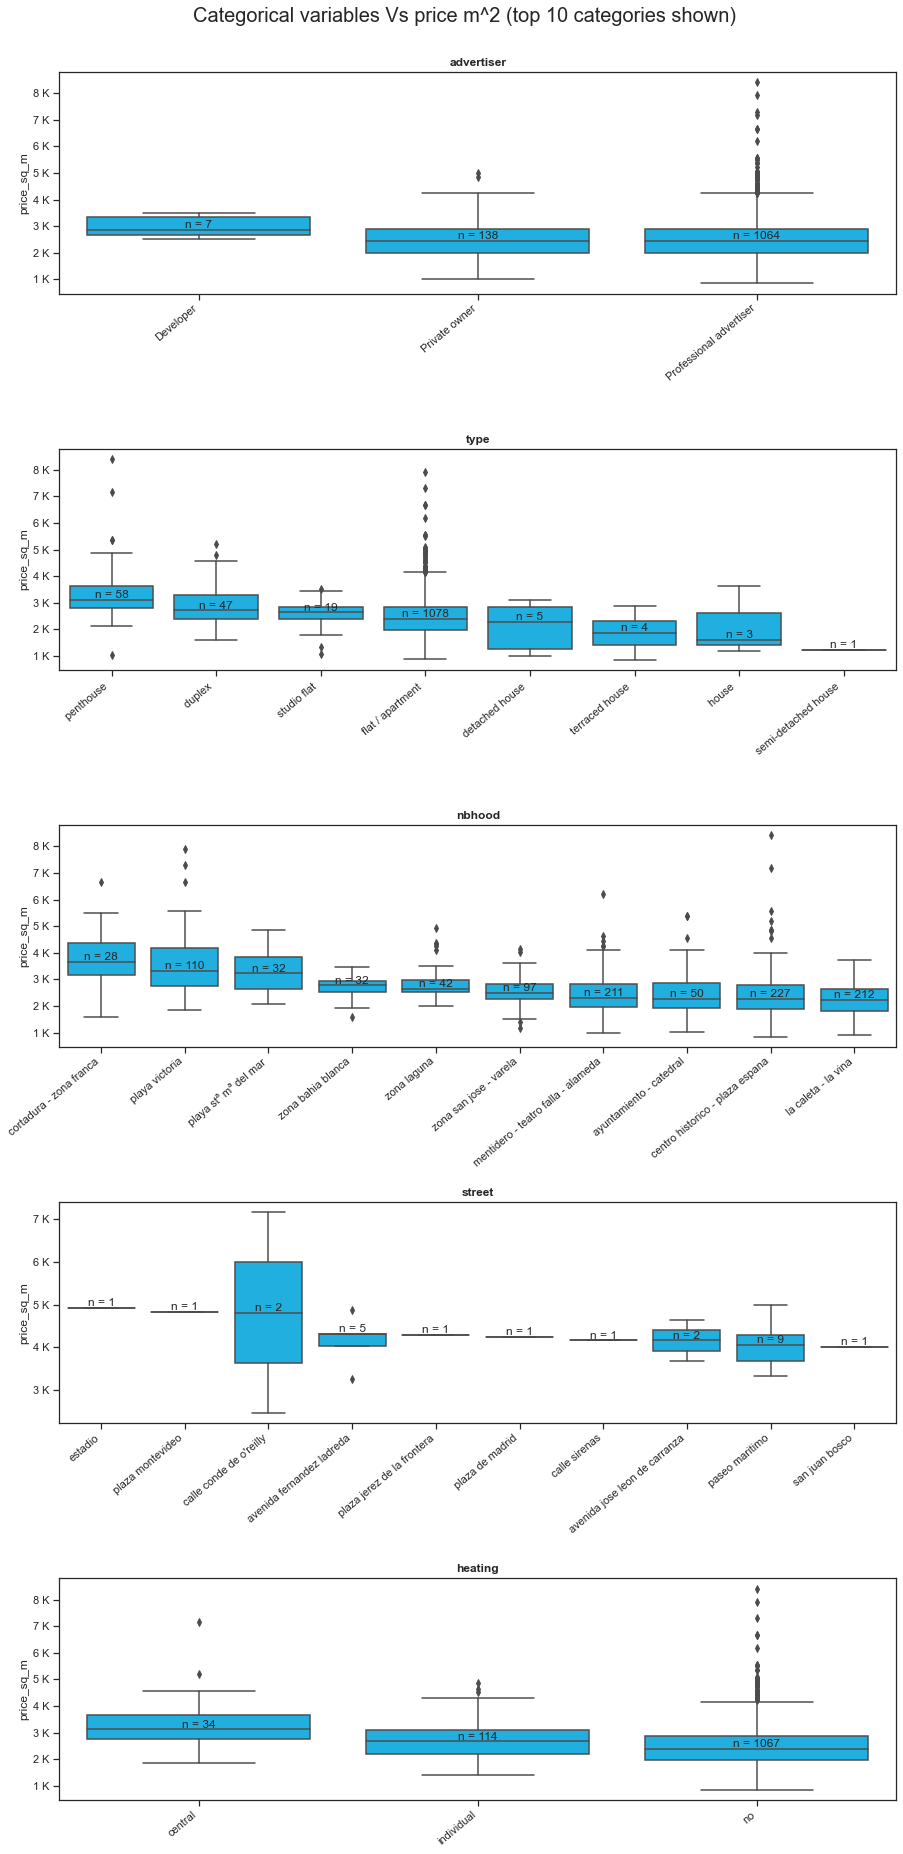

In [363]:
fig, axes = plt.subplots(5, 1, figsize=(15, 30))
axes = axes.flatten()
fig.suptitle('Categorical variables Vs price m^2 (top 10 categories shown)', fontsize=20, y=0.93)
fig.subplots_adjust(hspace=0.7, bottom=0.1, top=0.9)


for i in range(len(categorical_vars)):
    medians_df_ordered = data[[categorical_vars[i], 'price_sq_m']].groupby(categorical_vars[i]).median().sort_values(by='price_sq_m', ascending=False).head(10)
    order = medians_df_ordered.index

    axes[i] = sns.boxplot(ax=axes[i], x=categorical_vars[i], y='price_sq_m', data=data, 
                            order = order, color='deepskyblue')
    
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(th_formater))
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(labels = axes[i].get_xticklabels(), rotation=40, ha='right')
    axes[i].set_title(categorical_vars[i], fontweight="bold")
    
    # Calculate number of obs per group & median to position labels
    medians = medians_df_ordered.values
    x_axis_vals = axes[i].get_xticks()
    nobs = data[categorical_vars[i]].value_counts()[0:10].values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    anotation_y = ((axes[i].get_ylim()[1] - axes[i].get_ylim()[0]) * 0.05 / 6.25)  +  medians # 6.25 is the hight of the yaxis in pixels aprox
    for j in range(len(medians)):
        n = data[data[categorical_vars[i]] == order[j]].shape[0]
        axes[i].annotate(f'n = {n}', (x_axis_vals[j], anotation_y[j]), horizontalalignment='center')
  

##### Coments

### 3.2 Folium map

In [367]:
#Read the geoJSON file using geopandas
geojson = gpd.read_file('barrios_cadiz.geojson')
geojson=geojson[['id','geometry']] #only select 'coty_code' and 'id' columns

geo_df = data[['nbhood', 'price_sq_m']].groupby("nbhood").agg('describe').droplevel(level=0, axis=1)
geo_df.reset_index(inplace=True)
geo_df = geojson.merge(geo_df, left_on="id", right_on='nbhood').round()
geo_df.head()

,id,geometry,nbhood,count,mean,std,min,25%,50%,75%,max
0,mentidero - teatro falla - alameda,"POLYGON ((-6.30594 36.53528, -6.30498 36.53448...",mentidero - teatro falla - alameda,211.0,2448.0,721.0,1000.0,1943.0,2315.0,2843.0,6190.0
1,la caleta - la vina,"POLYGON ((-6.29547 36.52979, -6.29591 36.53017...",la caleta - la vina,212.0,2261.0,534.0,900.0,1806.0,2222.0,2638.0,3741.0
2,ayuntamiento - catedral,"POLYGON ((-6.29595 36.52842, -6.29435 36.52777...",ayuntamiento - catedral,50.0,2571.0,921.0,1036.0,1937.0,2267.0,2855.0,5370.0
3,playa stª mª del mar,"POLYGON ((-6.28803 36.52586, -6.28835 36.52566...",playa stª mª del mar,32.0,3278.0,744.0,2071.0,2630.0,3225.0,3838.0,4865.0
4,playa victoria,"POLYGON ((-6.27370 36.50075, -6.27443 36.50201...",playa victoria,110.0,3491.0,1064.0,1852.0,2761.0,3305.0,4165.0,7917.0


In [227]:
m = folium.Map(location=[36.518336, -6.279346], zoom_start=13, tiles = 'cartodbpositron')

folium.Choropleth(
            geo_data='barrios_cadiz.geojson',
            data=geo_df,
            columns=['nbhood', 'mean'],  #Here we tell folium to get the nbhood and plot mean price for each nbhood
            key_on='feature.properties.id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            fill_color='YlOrRd',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.6,
            line_opacity=0.2,
            legend_name='Mean price', #title of the legend
            highlight=True,
            line_color='black').add_to(m) 


# Add Customized Tooltips to the map
folium.features.GeoJson(
                    data=geo_df,
                    name='',
                    smooth_factor=2,
                    style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['nbhood', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
                        aliases=['nbhood', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(m) 

m


##### Coments